# CAB420, Practical 6 - Question 2 Solution
Linear Discriminant Analysis is designed to find a re-projection of the data such that it maximises the distance between the classes, while ensuring that samples of the same class are tightly grouped. As such, it has been widely applied to biometrics. One such method is FisherFaces, which applies PCA and then LDA to help group faces of the same subject. In brief, FisherFaces operates as follows:
* Construct an image matrix, where each row is a vectorised version of an image (i.e. as was done for EigenFaces)
* Project this matrix into an N-C space (N is the number of samples or dimensions, which ever is smaller; C is the number of unique classes) using PCA.
* Apply LDA to the subspace that results from the PCA transform, i.e.:
 * Compute the between class scatter matrix in the projected space;
 * Compute the within class scatter matrix in the projected space;
 * Compute the eigenvalues and eigenvectors of the ratio of the scatter matrices.
* Learn a classifier (i.e. k-nearest neighbours) in the final LDA space.

New samples can now be mapped to the FisherFace space by applying the PDA projection followed by the LDA projection. Using this classifier:
* Compare the performance of the two methods using the test set of the YaleB dataset.
* Compare the performance of the two methods using the two additional datasets: Yale_32x32.mat and ORL_32x32.mat. You should not re-train the PCA or LDA subspace using this data.
* Compare the performance of EigenFaces as the number of retained PCA components changes, to FisherFaces when equivalent changes are made to the number of retained components in the LDA space (note, do not reduce the number of components in the initial PCA projection for FisherFaces).

More information on FisherFaces can be found in the original paper, or online in posts such as this one: https://www.bytefish.de/blog/fisherfaces/.

In [2]:
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

## Part 1: Preliminaries
Load data, compute PCA space, etc. This is identical to Q1.

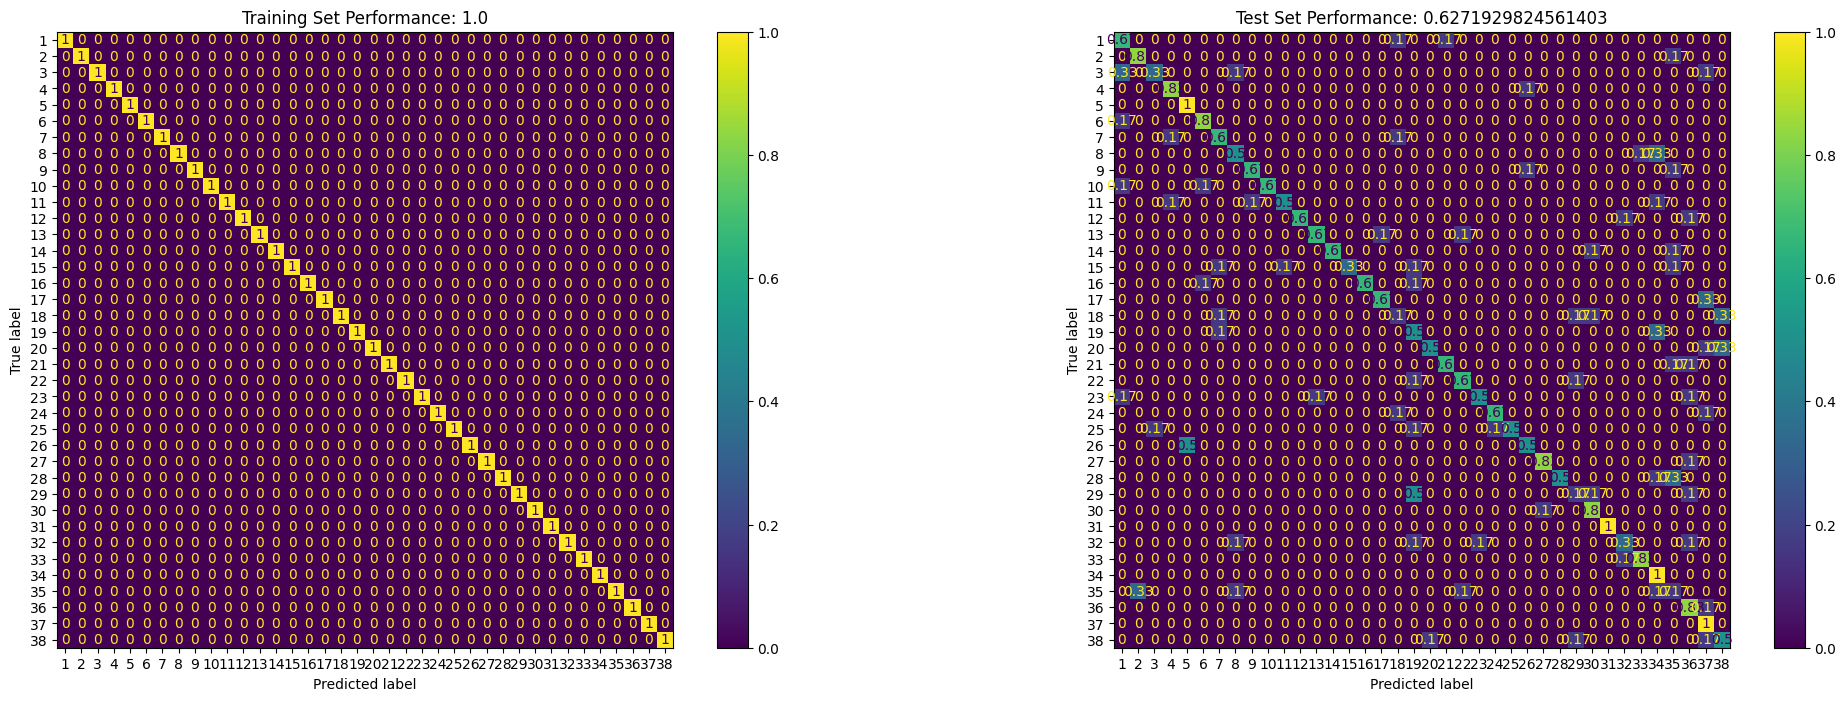

In [3]:
yale_b = scipy.io.loadmat('./YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]
train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

pca = decomposition.PCA()
pca.fit(train_fea)
transformed = pca.transform(train_fea)
transformed_test = pca.transform(test_fea)

cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
top95 = numpy.where(cumulative_sum > 0.95)[0][0]

transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));
    
cknn_95 = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_95.fit(transformed_train_95, train_gnd)
eval_model(cknn_95, transformed_train_95, train_gnd, transformed_test_95, test_gnd)    

## Compute LDA

Get our number of dimensions to retain from PCA, we have 1024 dimensions (32x32 images), so subtract from this the number of classes

In [4]:
pca_coeff_for_lda = 1024 - len(numpy.unique(train_gnd))

transformed_train_for_lda = transformed[:, 0:pca_coeff_for_lda]
transformed_test_for_lda = transformed_test[:, 0:pca_coeff_for_lda]

Get our LDA transform

In [5]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(numpy.array(transformed_train_for_lda), numpy.array(train_gnd))
transformed = lda.transform(transformed_train_for_lda)
print(numpy.shape(transformed))
transformed_test = lda.transform(transformed_test_for_lda)

(2196, 37)


We're not going to visualise our LDA faces as we did with PCA. The resultant images don't make as much sense, as they're are now attempting to show what the most discriminant parts of the face are, and so are much harder to interperet.

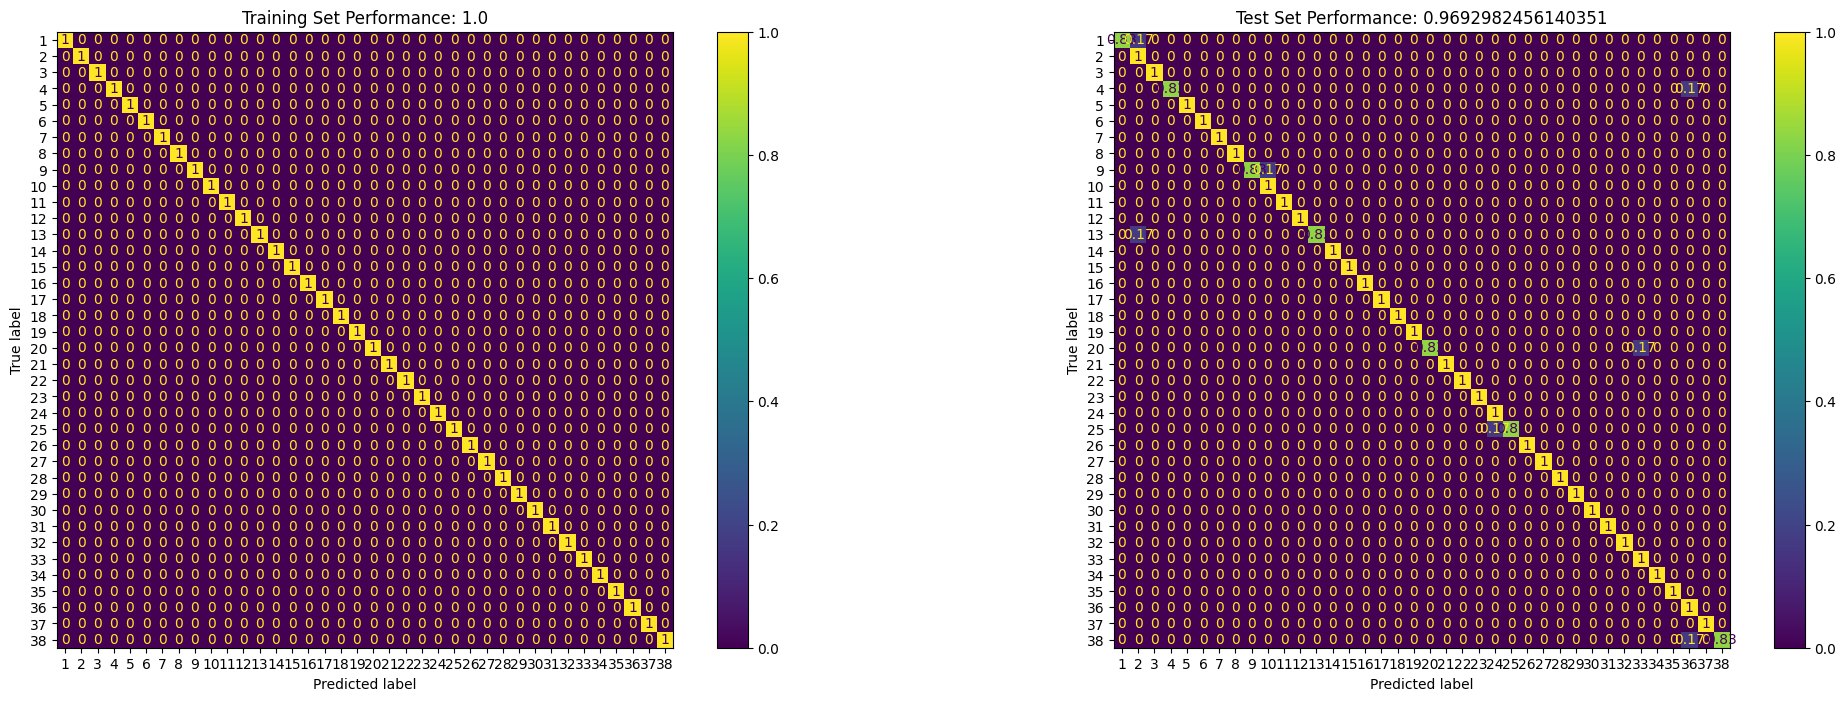

In [6]:
cknn_lda = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_lda.fit(transformed, train_gnd)
eval_model(cknn_lda, transformed, train_gnd, transformed_test, test_gnd)    

## Part 2: Other Databases
### ORL
Using the same data prep as the first question.

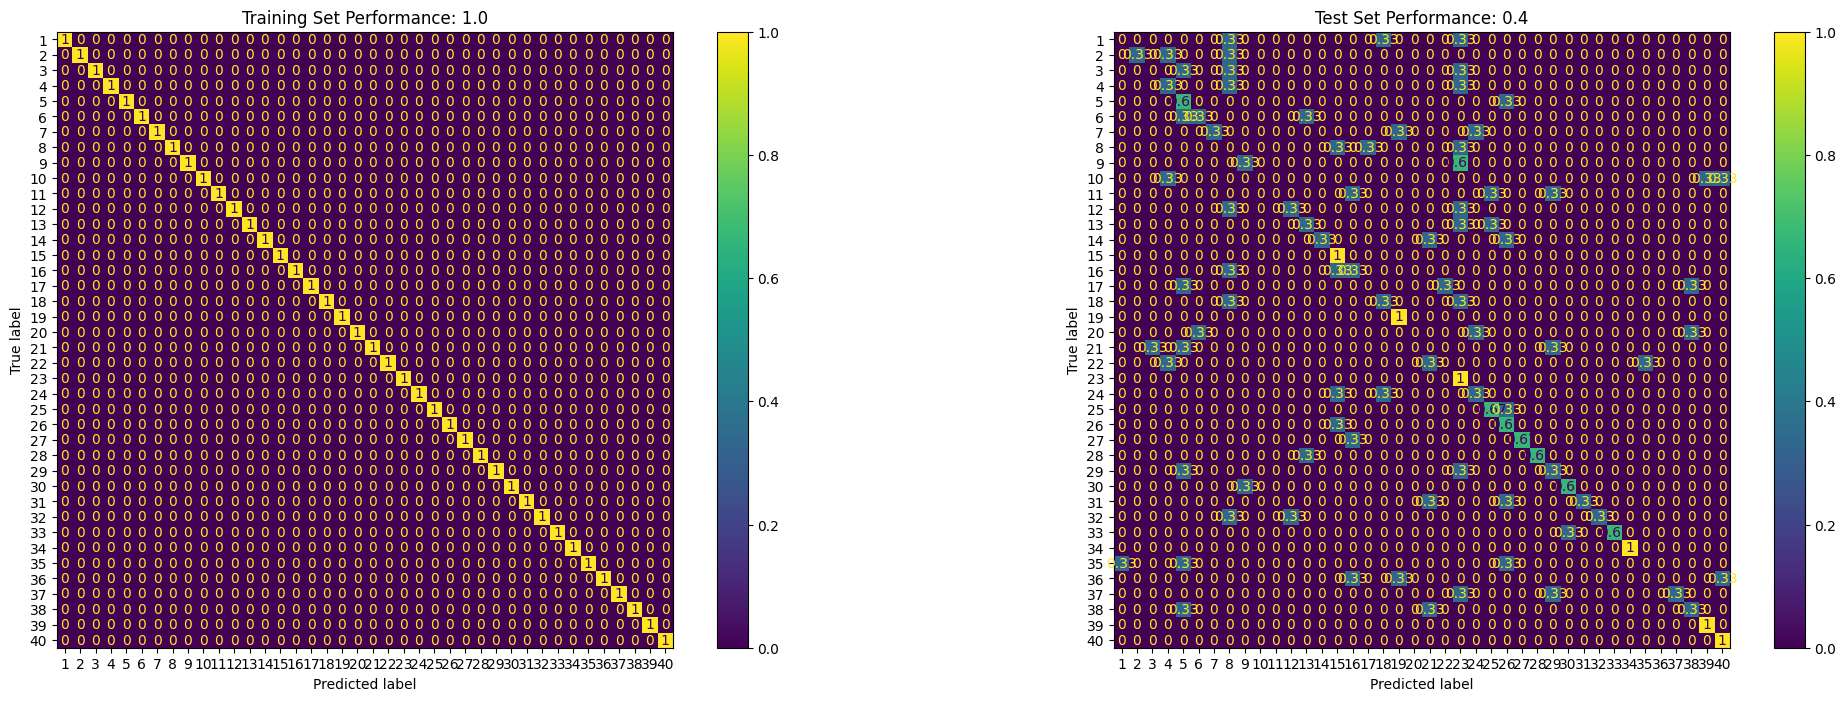

In [8]:
orl = scipy.io.loadmat('./ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

train_frames = []
for i in range(40):
    for j in range(7):
        train_frames.append(i*10 + j)
        
train_orl_fea = fea[train_frames, :]
train_orl_gnd = gnd[train_frames, :]
test_orl_fea = fea
test_orl_gnd = gnd
test_orl_fea = numpy.delete(test_orl_fea, train_frames, 0)
test_orl_gnd = numpy.delete(test_orl_gnd, train_frames, 0)
train_orl_gnd = numpy.reshape(train_orl_gnd, -1)
test_orl_gnd = numpy.reshape(test_orl_gnd, -1)

transformed = pca.transform(train_orl_fea)
transformed_test = pca.transform(test_orl_fea)
transformed_train_for_lda = transformed[:, 0:pca_coeff_for_lda]
transformed_test_for_lda = transformed_test[:, 0:pca_coeff_for_lda]

transformed = lda.transform(transformed_train_for_lda)
transformed_test = lda.transform(transformed_test_for_lda)

cknn_lda = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_lda.fit(transformed, train_orl_gnd)
eval_model(cknn_lda, transformed, train_orl_gnd, transformed_test, test_orl_gnd)    

### Yale

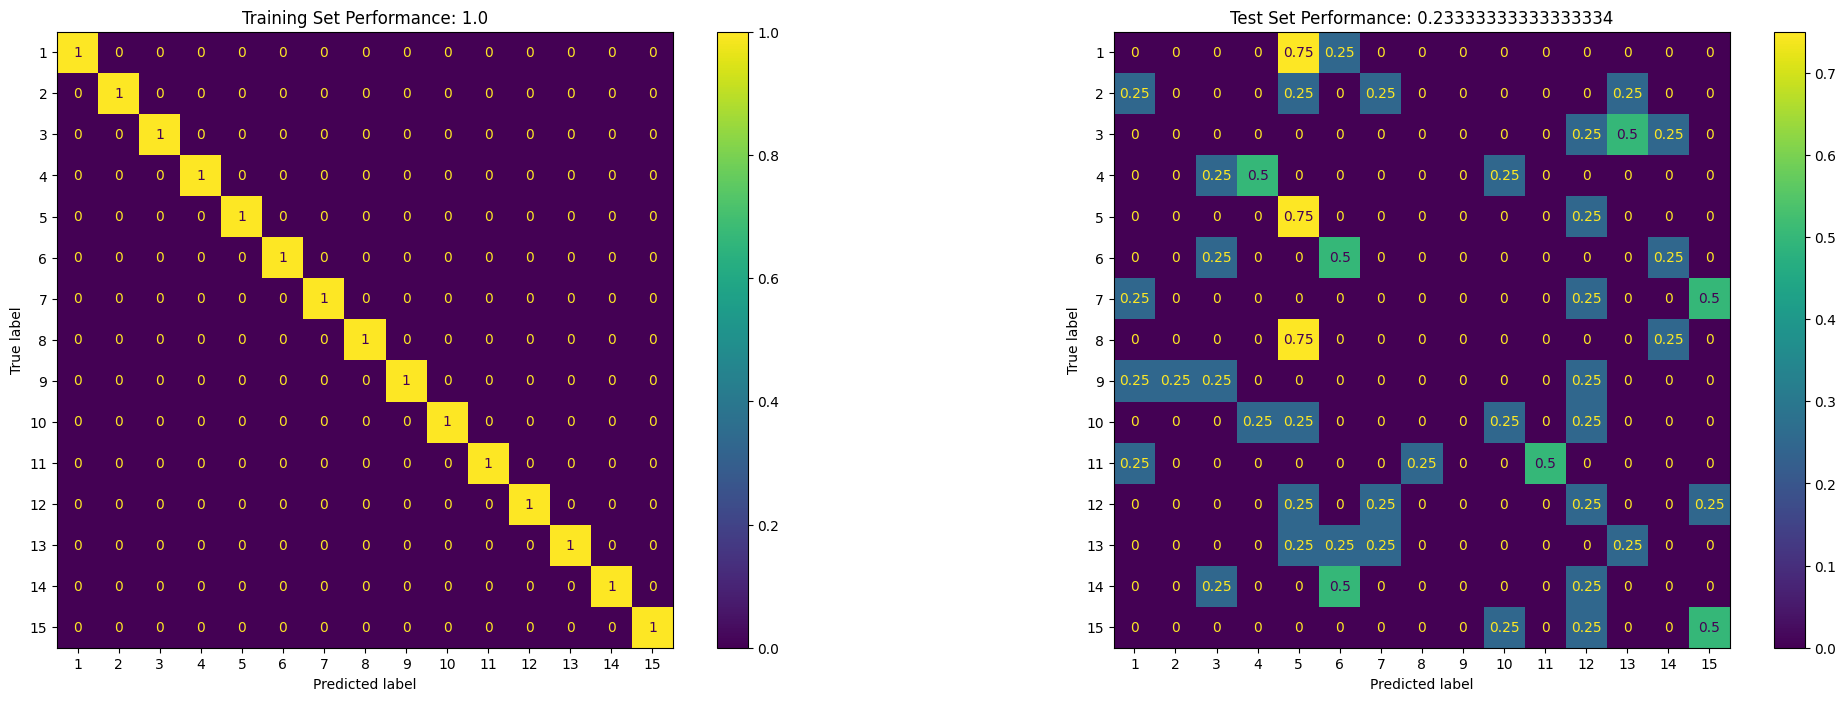

In [9]:
yale = scipy.io.loadmat('./Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])

train_frames = []
for i in range(15):
    for j in range(7):
        train_frames.append(i*11 + j)

train_yale_fea = fea[train_frames, :]
train_yale_gnd = gnd[train_frames, :]
test_yale_fea = fea
test_yale_gnd = gnd
test_yale_fea = numpy.delete(test_yale_fea, train_frames, 0)
test_yale_gnd = numpy.delete(test_yale_gnd, train_frames, 0)
train_yale_gnd = numpy.reshape(train_yale_gnd, -1)
test_yale_gnd = numpy.reshape(test_yale_gnd, -1)

transformed = pca.transform(train_yale_fea)
transformed_test = pca.transform(test_yale_fea)
transformed_train_for_lda = transformed[:, 0:pca_coeff_for_lda]
transformed_test_for_lda = transformed_test[:, 0:pca_coeff_for_lda]

transformed = lda.transform(transformed_train_for_lda)
transformed_test = lda.transform(transformed_test_for_lda)

cknn_lda = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_lda.fit(transformed, train_yale_gnd)
eval_model(cknn_lda, transformed, train_yale_gnd, transformed_test, test_yale_gnd)    

### These didn't work as well. Why?
* Our LDA space is trained to discriminate between the faces in YaleB, if the faces in the other data are not quite the same (pose, lighting, etc) then the transform may not work
* Need to avoid a mismatch in data conditions, these have a big impact on our LDA space. This is why faces are normalised, cropped, etc. But as we saw when applying PCA, there are differences in the data (which impact reconstruction accuracy) and which cause problems here.


## Thoughts and Comments
* LDA leads to better performance, but only when we have a good match between our training and testing data. If we have a poor match, results can get worse